# Calculate scDRS scores for different parameters

In [1]:
%load_ext lab_black
import os, sys

In [2]:
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md
import submitit
import os
from os.path import join
import glob
import shutil
import yaml
import pandas as pd
import numpy as np

from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


def zsc2pval(zsc):
    import scipy

    return 1 - scipy.stats.norm.cdf(zsc)

In [3]:
def process_magma(window_size):
    assert window_size in [0, 10, 50]
    zstat_file = f"/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/MAGMA-v108/MAGMA_v108_GENE_{window_size}_ZSTAT.txt"
    df = pd.read_csv(zstat_file, sep="\t")
    dic_ranked_gene_list = dict()
    for trait in df.columns:
        dic_ranked_gene_list[trait] = (
            df[trait].dropna().sort_values(ascending=False).index.tolist()
        )
    return dic_ranked_gene_list

In [4]:
window_size = 10

In [5]:
df_trait_info = pd.read_excel(
    "https://www.dropbox.com/s/4klqj17l05lqeqf/supp_tables_submission.xlsx?dl=1",
).set_index("Trait_Identifier")

In [6]:
zstat_file = f"/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/MAGMA-v108/MAGMA_v108_GENE_{window_size}_ZSTAT.txt"
df_zstat = pd.read_csv(zstat_file, sep="\t")

In [7]:
trait_list = [
    "UKB_460K.body_BMIz",
    "UKB_460K.body_HEIGHTz",
    "PASS_IBD_deLange2017",
    "UKB_460K.blood_RBC_DISTRIB_WIDTH",
    "PASS_Schizophrenia_Pardinas2018",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.pigment_HAIR",
    "UKB_460K.biochemistry_Triglycerides",
    #     "UKB_460K.lung_FVCzSMOKE",
    #     "UKB_460K.cov_EDU_COLLEGE",
]

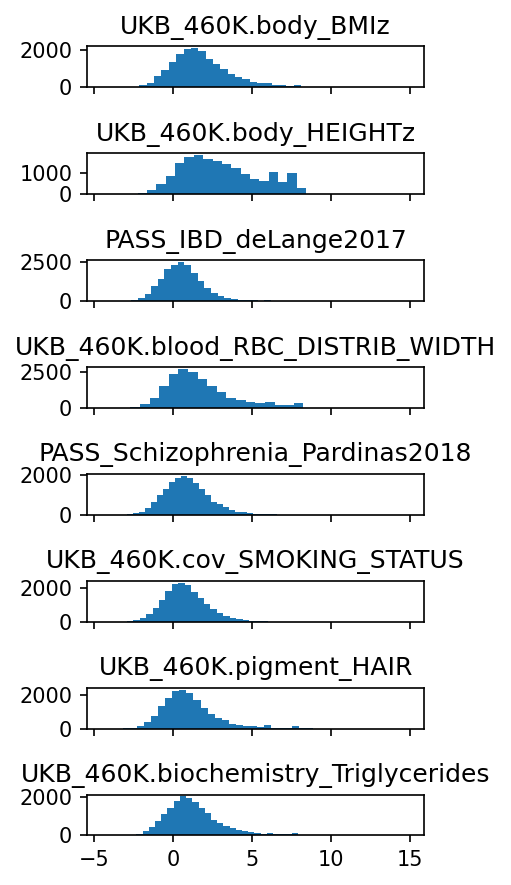

In [10]:
fig, axes = plt.subplots(figsize=(3, 6), nrows=len(trait_list), dpi=150, sharex=True)

for i, trait in enumerate(trait_list):
    zsc = df_zstat[trait].dropna()
    pval = zsc2pval(zsc)
    fdr = multipletests(pval, method="fdr_bh")[1]
    axes[i].hist(zsc, bins=30)
    axes[i].set_title(trait)

fig.show()
plt.tight_layout()

In [56]:
df_info = {
    "trait": [],
    "#(FDR < 0.1)": [],
    "#(FDR < 0.05)": [],
    "#(FDR < 0.01)": [],
    "#(FWER < 0.05)": [],
    "#(FWER < 0.01)": [],
    "hsq_z": [],
}
for i, trait in enumerate(df_trait_info.index):
    zsc = df_zstat[trait].dropna()
    pval = zsc2pval(zsc)
    fdr = multipletests(pval, method="fdr_bh")[1]
    fwer = multipletests(pval, method="bonferroni")[1]

    df_info["trait"].append(trait)
    for t in [0.01, 0.05, 0.1]:
        df_info[f"#(FDR < {t})"].append(np.sum(fdr < t))
    for t in [0.01, 0.05]:
        df_info[f"#(FWER < {t})"].append(np.sum(fwer < t))
    df_info["hsq_z"].append(df_trait_info.loc[trait, "Z"])

df_info = pd.DataFrame(df_info)

In [54]:
df_info.to_csv("df_info.csv", index=False)

In [58]:
method_list = df_info.columns[1:6]

In [59]:
method_list

Index(['#(FDR < 0.1)', '#(FDR < 0.05)', '#(FDR < 0.01)', '#(FWER < 0.05)',
       '#(FWER < 0.01)'],
      dtype='object')

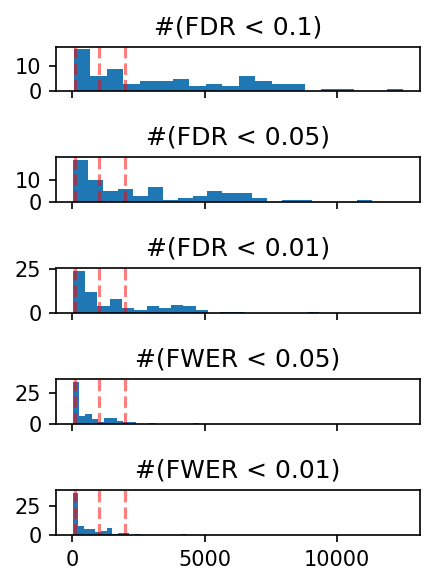

In [61]:
fig, axes = plt.subplots(figsize=(3, 4), dpi=150, nrows=5, sharex=True)
for i, method in enumerate(method_list):
    ax = axes[i]
    ax.hist(df_info[method], bins=20)
    for x in [100, 1000, 2000]:
        ax.axvline(x=x, color="red", ls="--", alpha=0.5)
    ax.set_title(method)
plt.tight_layout()

In [62]:
for i, method in enumerate(method_list):
    print(
        f"[{method}] #traits with <100 genes: {sum(df_info[method] < 100)}, #traits with >1000 genes: {sum(df_info[method] > 1000)}, #traits with >2000 genes: {sum(df_info[method] > 2000)}"
    )

[#(FDR < 0.1)] #traits with <100 genes: 2, #traits with >1000 genes: 54, #traits with >2000 genes: 42
[#(FDR < 0.05)] #traits with <100 genes: 5, #traits with >1000 genes: 47, #traits with >2000 genes: 36
[#(FDR < 0.01)] #traits with <100 genes: 12, #traits with >1000 genes: 37, #traits with >2000 genes: 24
[#(FWER < 0.05)] #traits with <100 genes: 20, #traits with >1000 genes: 20, #traits with >2000 genes: 6
[#(FWER < 0.01)] #traits with <100 genes: 23, #traits with >1000 genes: 19, #traits with >2000 genes: 3


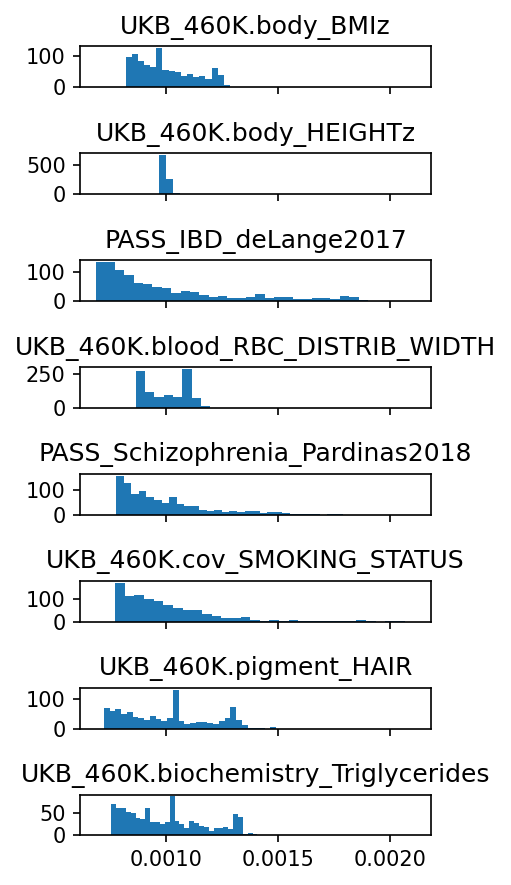

In [130]:
fig, axes = plt.subplots(figsize=(3, 6), nrows=len(trait_list), dpi=150, sharex=True)
for i, trait in enumerate(trait_list):
    zsc = df_zstat[trait].dropna()
    df_weight = zsc.sort_values(ascending=False).iloc[0:1000]
    df_weight /= df_weight.sum()
    axes[i].hist(df_weight, bins=30)
    axes[i].set_title(trait)

fig.show()
plt.tight_layout()
df_info = pd.DataFrame(df_info)

<ipython-input-132-09c891b61e56>:5: RuntimeWarning: divide by zero encountered in log10
  axes[i].scatter(zsc, -np.log10(pval), s=2)


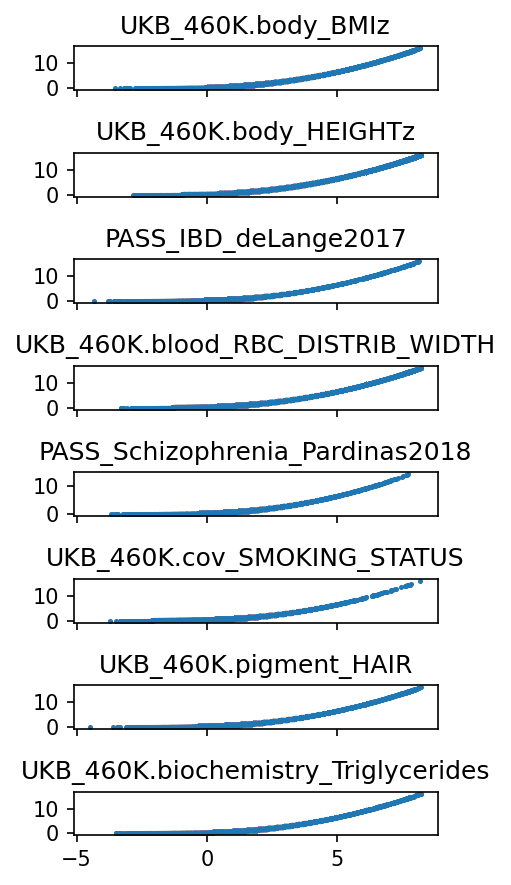

In [132]:
fig, axes = plt.subplots(figsize=(3, 6), nrows=len(trait_list), dpi=150, sharex=True)
for i, trait in enumerate(trait_list):
    zsc = df_zstat[trait].dropna()
    pval = zsc2pval(zsc)
    axes[i].scatter(zsc, -np.log10(pval), s=2)
    axes[i].set_title(trait)

fig.show()
plt.tight_layout()

In [88]:
dict_gene_list = {}
for trait in trait_list:
    zsc = df_zstat[trait].dropna()
    dict_gene_list[trait] = zsc.sort_values(ascending=False).iloc[0:1000]

In [90]:
trait_list

['UKB_460K.body_BMIz',
 'UKB_460K.body_HEIGHTz',
 'UKB_460K.lung_FVCzSMOKE',
 'PASS_IBD_deLange2017',
 'UKB_460K.blood_RBC_DISTRIB_WIDTH',
 'PASS_Schizophrenia_Pardinas2018',
 'UKB_460K.cov_SMOKING_STATUS',
 'UKB_460K.cov_EDU_COLLEGE',
 'UKB_460K.pigment_HAIR',
 'UKB_460K.biochemistry_Triglycerides']

In [95]:
len(
    set(dict_gene_list["UKB_460K.cov_SMOKING_STATUS"].index)
    & set(dict_gene_list["PASS_Schizophrenia_Pardinas2018"].index)
)

169

In [117]:
g1 = pd.DataFrame(dict_gene_list["PASS_Schizophrenia_Pardinas2018"])
g2 = pd.DataFrame(dict_gene_list["UKB_460K.body_HEIGHTz"])

In [118]:
df_merged = pd.merge(g1, g2, left_index=True, right_index=True)

In [133]:
df_merged

,PASS_Schizophrenia_Pardinas2018,UKB_460K.body_HEIGHTz
AS3MT,6.7952,7.8113
FOXP1,6.7471,9.1861
BAG5,6.5599,7.7338
CYP17A1,6.5589,7.7092
GIGYF2,6.4426,7.6635
...,...,...
PRUNE,3.4237,7.7846
HP1BP3,3.4197,7.9110
TMOD4,3.4166,7.9817
YWHAB,3.3959,7.6876


In [120]:
from scipy.stats import pearsonr

In [121]:
pearsonr(df_merged.iloc[:, 0], df_merged.iloc[:, 1])

(0.07267151621400084, 0.45056295308684907)

In [ ]:
fig, axes = plt.subplots(figsize=(3, 10), nrows=len(trait_list), dpi=150, sharex=True)
for i, trait in enumerate(trait_list):
    zsc = df_zstat[trait].dropna()
    pval = zsc2pval(zsc)
    axes[i].scatter(zsc, -np.log10(pval), s=2)
    axes[i].set_title(trait)

fig.show()
plt.tight_layout()

In [41]:
# table: (1) trait (2) # FDR < 0.1 (3) # FDR < 0.05 (4) z-score > 3 (5) hsq z-score
# histograms: example histograms for a few traits.

In [4]:
with open("../url_dict.yaml") as f:
    url_dict = yaml.safe_load(f)

In [5]:
list_trait = pd.read_excel(
    "https://www.dropbox.com/s/qojbzu5zln33j7f/supp_tables.xlsx?dl=1", sheet_name=0
)["Trait_Identifier"].values

In [6]:
# download from MAGMA websites
gene_loc_path = "../data/gene_loc/NCBI37.3.gene.loc"
gene_loc = pd.read_csv(
    gene_loc_path,
    delim_whitespace=True,
    header=None,
    usecols=[1, 2, 3, 5],
    names=["CHR", "START", "STOP", "GENE"],
)

In [7]:
for window_size in [0, 10, 50]:
    out_dir = f"./geneset/{window_size}kb"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    dic_ranked_gene_list = process_magma(window_size)
    for trait in list_trait:
        with open(join(out_dir, f"{trait}.txt"), "w") as f:
            f.writelines("\n".join(dic_ranked_gene_list[trait]))

In [8]:
list_gs_name = [
    f"{window_size}kb.{n_gene}"
    for window_size in [10]
    for n_gene in [100, 500, 1000, 2000]
] + [f"{window_size}kb.{n_gene}" for window_size in [0, 50] for n_gene in [1000]]

In [9]:
for gs_name in list_gs_name:
    window_size, top_n_gene = gs_name.split(".")
    window_size = window_size[:-2]
    top_n_gene = int(top_n_gene)
    print(window_size, top_n_gene)
    df = {"TRAIT": [], "GENESET": []}
    for trait in list_trait:
        file = f"./geneset/{window_size}kb/{trait}.txt"
        with open(file) as f:
            gene_list = [line.strip() for line in f.readlines()]
        df["TRAIT"].append(trait)
        df["GENESET"].append(",".join(gene_list[0:top_n_gene]))
    df = pd.DataFrame(df)
    df.to_csv(
        join(f"geneset/{window_size}kb.{top_n_gene}.gs"),
        sep="\t",
        index=False,
    )

10 100
10 500
10 1000
10 2000
0 1000
50 1000


In [16]:
DATASET = "tms_facs"
for gs_name in list_gs_name:
    print(gs_name)
    window_size, top_n_gene = gs_name.split(".")
    window_size = window_size[:-2]
    df = pd.read_csv(f"geneset/{window_size}kb.{top_n_gene}.gs", sep="\t")
    todo_df = []
    for _, row in df.iterrows():
        if not os.path.exists(
            join(
                f"{DATASET}/score_file/{window_size}kb.{top_n_gene}",
                row.TRAIT + ".score.gz",
            )
        ):
            todo_df.append(row)

    batch_size = 1
    # generate batch gs
    batch_dir = join(f"{DATASET}/geneset", f"{window_size}kb.{top_n_gene}.gs.batch")
    if os.path.exists(batch_dir):
        shutil.rmtree(batch_dir)

    if len(todo_df) == 0:
        continue

    os.makedirs(batch_dir)
    todo_df = pd.concat(todo_df, axis=1).T

    batch_dfs = np.array_split(todo_df, int(np.ceil(todo_df.shape[0] / batch_size)))
    for batch_i, batch_df in enumerate(batch_dfs):
        batch_df.to_csv(join(batch_dir, f"batch{batch_i}.gs"), sep="\t", index=False)

10kb.100
10kb.500
10kb.1000
10kb.2000
0kb.1000
50kb.1000
